[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/ConvNets.ipynb)

# Convolutional Neural Networks for Images

Our goal is to implement a Convolutional Neural Network (ConvNet) for image classification using PyTorch. We'll use the MNIST dataset, which contains 70,000 grayscale images of handwritten digits (0-9). To make training faster on CPU, we'll downscale images from 28×28 to 14×14 pixels.

ConvNets are designed to exploit the spatial structure in images. Unlike fully connected networks that treat each pixel independently, ConvNets use:
- **Convolutional layers**: Apply learned filters to detect local patterns (edges, textures, etc.)
- **Pooling layers**: Downsample spatial dimensions while preserving important features
- **Spatial hierarchy**: Early layers detect simple features, deeper layers combine them into complex patterns

In [23]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For loading CIFAR-10 dataset
import torchvision
import torchvision.transforms as transforms

# Set random seeds for reproducibility
# This ensures results are consistent across runs
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
# We'll default to CPU but provide the option to use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Loading MNIST Dataset

MNIST contains 70,000 28×28 grayscale images of handwritten digits:
- **Training set**: 60,000 images
- **Test set**: 10,000 images
- **Classes**: Digits 0-9 (10 classes)

We'll apply transformations to:
1. Resize from 28×28 to 14×14 (faster training on CPU)
2. Convert PIL images to PyTorch tensors
3. Normalize pixel values to have mean 0 and std 1 (improves training stability)

In [24]:
# Define transformations for the dataset
# Compose chains multiple transformations together
transform = transforms.Compose([
    # Resize images from 28x28 to 14x14 for faster CPU training
    # Bilinear interpolation preserves smoothness
    transforms.Resize((14, 14)),
    
    # Convert PIL Image to PyTorch tensor
    # This changes the shape from (H, W) to (1, H, W) for grayscale
    # and scales pixel values from [0, 255] to [0, 1]
    transforms.ToTensor(),
    
    # Normalize with MNIST mean and std (computed across dataset)
    # This centers data around 0 and scales to unit variance
    # mean=0.5, std=0.5 scales roughly to [-1, 1] range
    # For grayscale, we use single values instead of [0.5, 0.5, 0.5]
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Download and load training dataset
# root='./data': where to save downloaded data
# train=True: get training split
# download=True: download if not already present
trainset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

# Download and load test dataset
testset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

# Create data loaders for batch processing
# DataLoader handles batching, shuffling, and parallel loading
# batch_size=64: process 64 images at a time (balance between speed and memory)
# shuffle=True: randomize order each epoch (important for training)
# num_workers=2: use 2 parallel processes to load data (speeds up loading)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=64, 
    shuffle=False,  # No need to shuffle test data
    num_workers=2
)

# MNIST class labels (digits)
classes = tuple(str(i) for i in range(10))

print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')
print(f'Number of classes: {len(classes)}')
print(f'Image shape after transform: {trainset[0][0].shape}')  # (C, H, W)

Training samples: 60000
Test samples: 10000
Number of classes: 10
Image shape after transform: torch.Size([1, 14, 14])


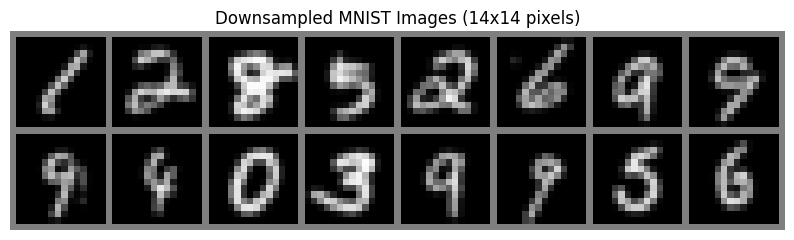

In [25]:
# Helper function to denormalize images for visualization
def imshow(img):
    """
    Display a tensor image by denormalizing and converting to numpy.
    
    Parameters:
    img: PyTorch tensor with shape (C, H, W) in range [-1, 1]
    """
    # Reverse the normalization: x_original = x_normalized * std + mean
    # Since we normalized with mean=0.5, std=0.5, we reverse it
    img = img * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    
    # Clip values to [0, 1] range (in case of numerical errors)
    img = torch.clamp(img, 0, 1)
    
    # Convert to numpy
    # For grayscale images, we need to squeeze the channel dimension
    # or transpose to (H, W, C) format for matplotlib
    npimg = img.numpy()
    if npimg.shape[0] == 1:  # Grayscale
        npimg = npimg.squeeze(0)  # Remove channel dimension: (1, H, W) -> (H, W)
        plt.imshow(npimg, cmap='gray')
    else:  # RGB
        npimg = np.transpose(npimg, (1, 2, 0))
        plt.imshow(npimg)
    
    plt.axis('off')  # Hide axes for cleaner visualization

# Get a batch of training images
# iter() creates an iterator, next() gets the first batch
# dataiter.next() returns (images, labels) tuple
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a grid of 16 images (4x4)
# images[:16] selects first 16 images from the batch
# torchvision.utils.make_grid arranges them in a grid
# nrow=4: 4 images per row
# padding=2: 2 pixels of padding between images
img_grid = torchvision.utils.make_grid(images[:16], nrow=8, padding=1)

# Display the grid
plt.figure(figsize=(10, 10))
imshow(img_grid)
plt.title('Downsampled MNIST Images (14x14 pixels)')
plt.show()


## Designing a Small ConvNet

We'll build a simple but effective architecture with relatively small number of parameters for fast CPU training


In [26]:
class ConvNet(nn.Module):
    """
    Simple Convolutional Neural Network for MNIST digit classification.
    
    Architecture: 2 conv layers + 2 FC layers
    Input: 14×14×1 grayscale images
    Output: 10 class scores (digits 0-9)
    """
    
    def __init__(self):
        """Initialize the layers of the ConvNet."""
        super(ConvNet, self).__init__()
        
        # First convolutional layer
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # in_channels=1: grayscale input (1 channel)
        # out_channels=16: learn 16 different filters
        # kernel_size=3: 3×3 filters
        # padding=1: add 1 pixel of zeros around border (keeps spatial size same)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        
        # Second convolutional layer
        # in_channels=16: takes output from conv1
        # out_channels=32: learn 32 different filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer (applied twice after each conv)
        # kernel_size=2: take max over 2×2 regions
        # stride=2: move 2 pixels at a time (no overlap)
        # This reduces spatial dimensions by factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # First fully connected layer
        # After conv1→pool→conv2→pool, spatial size is 14→7→3
        # 3×3×32 = 288 features after flattening
        # Map 288 → 64 hidden units
        self.fc1 = nn.Linear(288, 64)
        
        # Second fully connected layer (output layer)
        # 64 → 10 class scores (one per digit 0-9)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Parameters:
        x: input images, shape (N, 1, 14, 14)
           N = batch size, 1 = grayscale channel, 14×14 = spatial dimensions
        
        Returns:
        out: class scores, shape (N, 10)
        """
        # First convolutional block: Conv → ReLU → Pool
        # x: (N, 1, 14, 14)
        x = self.conv1(x)  # Shape: (N, 16, 14, 14) - 16 feature maps, same spatial size
        x = F.relu(x)      # Shape: (N, 16, 14, 14) - ReLU activation (element-wise)
        x = self.pool(x)   # Shape: (N, 16, 7, 7) - max pooling reduces spatial size by 2
        
        # Second convolutional block: Conv → ReLU → Pool
        x = self.conv2(x)  # Shape: (N, 32, 7, 7) - 32 feature maps
        x = F.relu(x)      # Shape: (N, 32, 7, 7)
        x = self.pool(x)   # Shape: (N, 32, 3, 3) - spatial size reduced to 3×3
        
        # Flatten spatial dimensions
        # x.view(x.size(0), -1) reshapes to (N, 32*3*3) = (N, 288)
        # x.size(0) is the batch size N
        # -1 means "infer this dimension" = 32*3*3 = 288
        x = x.view(x.size(0), -1)  # Shape: (N, 288)
        
        # First fully connected layer with ReLU
        x = self.fc1(x)    # Shape: (N, 64)
        x = F.relu(x)      # Shape: (N, 64)
        
        # Output layer (no activation - raw scores for cross-entropy loss)
        x = self.fc2(x)    # Shape: (N, 10) - one score per class
        
        return x

# Instantiate the model and move to device (CPU or GPU)
model = ConvNet().to(device)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 23,946
Trainable parameters: 23,946


In [27]:
# Define loss function
# CrossEntropyLoss expects raw scores (logits), applies softmax internally
criterion = nn.CrossEntropyLoss()

# Define optimizer
# SGD with momentum: v_t = momentum * v_{t-1} + gradient
#                    w_t = w_{t-1} - lr * v_t
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Create validation split from training data
# Use 80% for training, 20% for validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

# random_split splits dataset
train_subset, val_subset = torch.utils.data.random_split(
    trainset, [train_size, val_size]
)

# Create data loaders for train and validation
trainloader_split = torch.utils.data.DataLoader(
    train_subset, batch_size=64, shuffle=True, num_workers=2
)
valloader = torch.utils.data.DataLoader(
    val_subset, batch_size=64, shuffle=False, num_workers=2
)

# Number of epochs (complete passes through training data)
num_epochs = 5

print('Starting training...')
print(f'Training batches per epoch: {len(trainloader_split)}')
print(f'Validation batches: {len(valloader)}')

for epoch in range(num_epochs):
    # ===== Training phase =====
    model.train()  # Set model to training mode (enables dropout, batch norm if present)
    
    running_loss = 0.0
    
    # Iterate over training batches
    # enumerate() provides batch index i
    # trainloader_split yields (images, labels) tuples
    for i, (images, labels) in enumerate(trainloader_split):
        # Move data to device (CPU or GPU)
        images = images.to(device)  # Shape: (64, 3, 16, 16)
        labels = labels.to(device)  # Shape: (64,)
        
        # Zero the parameter gradients from previous iteration
        # Gradients accumulate by default, so we must clear them
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        outputs = model(images)  # Shape: (64, 10)
        
        # Compute loss
        # outputs: raw scores (logits), labels: ground truth class indices
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients automatically via backpropagation
        # This is where PyTorch shines - no manual gradient calculation!
        loss.backward()
        
        # Update weights using computed gradients
        # optimizer.step() performs: w = w - lr * gradient
        optimizer.step()
        
        # Accumulate loss for this epoch
        running_loss += loss.item()
        
        # Print progress every 100 batches
        if i % 100 == 99:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Batch [{i+1}/{len(trainloader_split)}], '
                  f'Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    
    # ===== Validation phase =====
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm updates)
    
    val_loss = 0.0
    train_loss_epoch = 0.0
    
    # Disable gradient computation for validation (saves memory, speeds up)
    with torch.no_grad():
        # Compute validation loss
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        # Compute training loss on full training set
        for images, labels in trainloader_split:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss_epoch += loss.item()
    
    # Average losses over all batches
    train_loss_avg = train_loss_epoch / len(trainloader_split)
    val_loss_avg = val_loss / len(valloader)
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_loss_avg:.4f}, '
          f'Val Loss: {val_loss_avg:.4f}')

print('Training complete!')

Starting training...
Training batches per epoch: 750
Validation batches: 188
Epoch [1/5], Batch [100/750], Loss: 2.2165
Epoch [1/5], Batch [200/750], Loss: 1.0047
Epoch [1/5], Batch [300/750], Loss: 0.4156
Epoch [1/5], Batch [400/750], Loss: 0.3164
Epoch [1/5], Batch [500/750], Loss: 0.2364
Epoch [1/5], Batch [600/750], Loss: 0.1967
Epoch [1/5], Batch [700/750], Loss: 0.1499
Epoch [1/5] - Train Loss: 0.1276, Val Loss: 0.1320
Epoch [2/5], Batch [100/750], Loss: 0.1365
Epoch [2/5], Batch [200/750], Loss: 0.1347
Epoch [2/5], Batch [300/750], Loss: 0.1054
Epoch [2/5], Batch [400/750], Loss: 0.1231
Epoch [2/5], Batch [500/750], Loss: 0.0871
Epoch [2/5], Batch [600/750], Loss: 0.0969
Epoch [2/5], Batch [700/750], Loss: 0.0993
Epoch [2/5] - Train Loss: 0.0856, Val Loss: 0.0910
Epoch [3/5], Batch [100/750], Loss: 0.0787
Epoch [3/5], Batch [200/750], Loss: 0.0778
Epoch [3/5], Batch [300/750], Loss: 0.0712
Epoch [3/5], Batch [400/750], Loss: 0.0737
Epoch [3/5], Batch [500/750], Loss: 0.0777
Epoc

In [28]:
# Evaluate model performance on the held-out test set

model.eval()  # Set to evaluation mode

correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in testloader:
        # Move to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = model(images)  # Shape: (N, 10) - raw scores
        
        # Convert scores to predicted class
        # torch.max returns (values, indices)
        # dim=1 means find max along class dimension
        # predicted has shape (N,) containing class indices
        _, predicted = torch.max(outputs.data, dim=1)
        
        # Count correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Correct: {correct}/{total}')


Test Accuracy: 98.66%
Correct: 9866/10000
